# Predict `Subject Age`

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path
import keras_tuner as kt

In [3]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [4]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
phenotype = 'Subject Age'

In [6]:
#load data
aging_dir = Path('/home/ubuntu/a/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 47)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

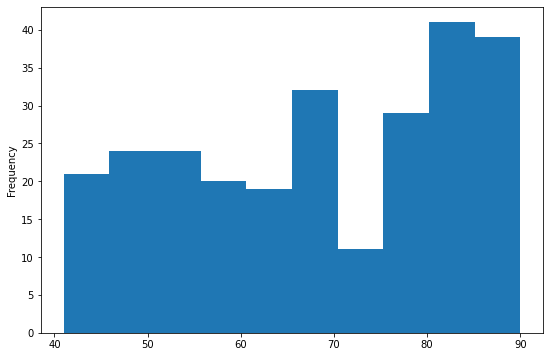

In [7]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [8]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [9]:
def model_builder(hp):
    hp_filters_l1 = hp.Int('filters_l1', min_value=3, max_value=15, step=3)
    hp_filters_l2 = hp.Int('filters_l2', min_value=3, max_value=15, step=3)
    model = Sequential([
        Input(shape=x[0].shape),
        Conv2D(hp_filters_l1, kernel_size = (1, x.shape[2]), activation=None),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(hp_filters_l2, kernel_size = (1,1), activation=None),
        BatchNormalization(),
        Activation('relu'),
        AveragePooling2D(pool_size = (x.shape[1], 1)),
        Flatten(),
        Dense(hp_filters_l2, activation=None),
        BatchNormalization(),
        Activation('relu'),
        Dense(1, activation=None),
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        loss=MeanAbsoluteError(),
        optimizer=Adam(learning_rate=hp_learning_rate),
        metrics=['mean_absolute_error'],
    )
    return model

In [25]:
bayesian_tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mean_absolute_error',
    max_trials=100,
    overwrite=True,
    directory = 'hp-search',
    project_name='aging_regression_bayesian',
)

In [26]:
%%time
bayesian_tuner.search(
    x_train, y_train,
    validation_split=0.2,
)

Trial 100 Complete [00h 00m 01s]
val_mean_absolute_error: 0.45498916506767273

Best val_mean_absolute_error So Far: 0.2432757169008255
Total elapsed time: 00h 04m 34s
INFO:tensorflow:Oracle triggered exit
CPU times: user 8min 51s, sys: 34 s, total: 9min 25s
Wall time: 4min 34s


In [10]:
# hyperband_tuner = kt.Hyperband(
#     model_builder,
#     objective='val_mean_absolute_error',
#     max_epochs=400,
#     factor=5,
#     overwrite=True,
#     directory='hp-search',
#     project_name='aging_regression_hyperband',
# )

In [11]:
# %%time
# hyperband_tuner.search(
#     x_train, y_train,
#     validation_split=0.2,
# )

Trial 55 Complete [00h 00m 01s]
val_mean_absolute_error: 0.3652605414390564

Best val_mean_absolute_error So Far: 0.25764623284339905
Total elapsed time: 00h 01m 18s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1min 20s, sys: 7.74 s, total: 1min 28s
Wall time: 1min 18s


In [27]:
tuner = bayesian_tuner

In [28]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'filters_l1': 6, 'filters_l2': 6, 'learning_rate': 0.001}

In [30]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5000, 1, 6)        168       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 6)        24        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 6)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 1, 6)        42        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 1, 6)        24        
_________________________________________________________________
activation_1 (Activation)    (None, 5000, 1, 6)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 6)           0

In [31]:
%%time
model_store = Path('Result/saved_weights.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(
    filepath=model_store, 
    monitor='val_loss',
    verbose=0, 
    save_best_only=True
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta = 1/age_range
)

st = time.time()
# model training
model.fit(
    [x_train], y_train,
    batch_size=60,
    epochs=200, 
    verbose=1,
    callbacks=[checkpointer],
    validation_data=([x_valid], y_valid)
)
rt = time.time()-st

Epoch 1/200
4/4 [==============================] - 1s 138ms/step - loss: 0.9085 - mean_absolute_error: 0.9085 - val_loss: 0.9598 - val_mean_absolute_error: 0.9598
Epoch 2/200
4/4 [==============================] - 0s 26ms/step - loss: 0.8634 - mean_absolute_error: 0.8634 - val_loss: 0.9257 - val_mean_absolute_error: 0.9257
Epoch 3/200
4/4 [==============================] - 0s 26ms/step - loss: 0.7689 - mean_absolute_error: 0.7689 - val_loss: 0.8852 - val_mean_absolute_error: 0.8852
Epoch 4/200
4/4 [==============================] - 0s 25ms/step - loss: 0.7410 - mean_absolute_error: 0.7410 - val_loss: 0.8406 - val_mean_absolute_error: 0.8406
Epoch 5/200
4/4 [==============================] - 0s 26ms/step - loss: 0.6749 - mean_absolute_error: 0.6749 - val_loss: 0.7987 - val_mean_absolute_error: 0.7987
Epoch 6/200
4/4 [==============================] - 0s 25ms/step - loss: 0.6446 - mean_absolute_error: 0.6446 - val_loss: 0.7592 - val_mean_absolute_error: 0.7592
Epoch 7/200
4/4 [==========

In [32]:
rt

21.595181226730347

Final train error: 6.064376898109913
Final valid error: 11.653904289007187


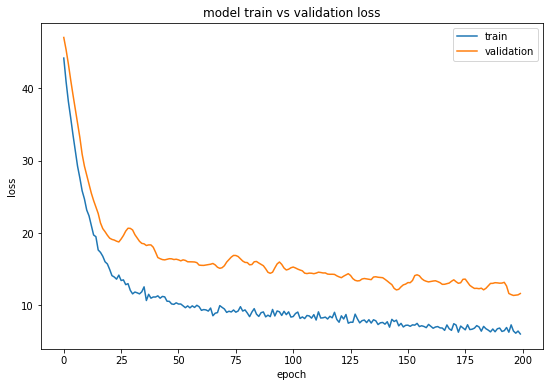

In [33]:
##### Step 6: plot train and validation loss #####
history = model.history
print('Final train error:', age_range*history.history['mean_absolute_error'][-1])
print('Final valid error:', age_range*history.history['val_mean_absolute_error'][-1])
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [34]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])

In [35]:
errors = age_range * (pd.Series(y_test)-pd.Series(y_scores))
errors.describe()

count    65.000000
mean      2.781096
std      14.224813
min     -31.566926
25%      -4.234917
50%       3.750099
75%      11.834390
max      38.030199
dtype: float64

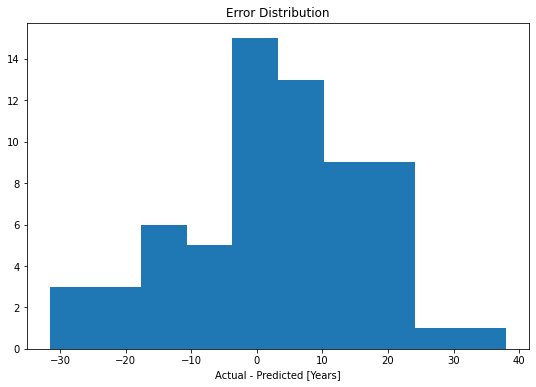

In [36]:
plt.hist(errors)
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

[ 0.59557238 25.8026039 ]


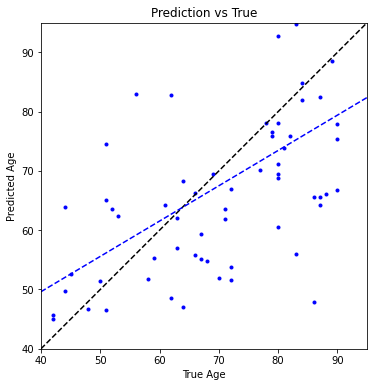

In [37]:
age_true = y_test*age_range + age_min
age_pred = y_scores*age_range + age_min
plt.plot(age_true, age_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(age_true, age_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()